# Feed Forward Neural Networks

## Reading
1. Goodfellow. Deep Learning
1. https://pytorch.org/tutorials/

## Outline

1. General architecture
1. Neuron
1. Layers
1. Activation functions
1. Losses
1. Regularization
1. Weight Initialization
1. Universal Approximators

## General Architecture

NN as a composition of functions

$$ F(x) = f_{w_n} x f_{w_{n-1}} x .. f_{w_1} (x) $$

<img src="images/ff.jpg" style="height:300px">

## Neuron

$$F(x)_i = \sum_{i=1}^N f(w_i^T x + b_i)$$

<img src="images/neuron.png" style="height:300px">

## Layers

<img src="images/weights.png" style="height:600px">

## Activation fuctions

Why we do not use linear activations?

<img src="images/act.png" style="height:600px">

## Losses

For now, we consider the same losses we already learned:
1. Crossentropy loss for classification
1. MSE loss for regression

## Regularization in neural networks

1. $L_p$ norm regularization on weights (usually avoided)  
1. Early stopping. Remember, that it is equivalent to $L_2$ norm regularization on weights  
1. Data augmentation. Create new samples from the same domain to increase size of your dataset. Remember generalization bounds.  
1. Dropout. Drop random nodes in a layer with probability $p$    



### Dropout

Theere are 2 interpretations for dropout:  
1. "Bagging" over neural networks  
1. Avoid feature coadaptation  

Difference between bagging and dropout:

$ p(y|x) = \frac 1 K \sum_{i=1}^K p_i(y|x)$ for bagging  

$ p(y|x) = \sum_{\mu} p(\mu) p(y | x, \mu)$ for dropout, where $\mu$ is mask on weights. There is an exponential number of masks for fixed number of weights, that makes dropout more effective than explicit bagging.  


<img src="images/drop.png" style="height:300px">


## Training neural network, SGD


### Vanilla SGD

<img src="images/sgd.gif" style="height:300px">


### SGD with momentum

$$ v_t = \gamma v_{t-1} + \eta \nabla_{\theta} J(\theta)$$
$$ \theta_t = \theta_{t-1} - v_t $$


### SGD with nesterov momentum

$$ v_t = \gamma v_{t-1} + \eta \nabla_{\theta} J(\theta - \gamma v_{t-1})$$
$$ \theta_t = \theta_{t-1} - v_t $$


<img src="images/nesterov.jpeg" style="height:300px">



### RmsProp

$$ g_t = \nabla_{\theta} J(\theta) $$
$$  E[g^2]_t = \alpha E[g^2]_{t-1} + (1-\alpha) g^2_t $$
$$  \theta_t = \theta_{t-1} - \frac {\eta} {\sqrt {E[g^2]_t} + \epsilon} g_t $$


###  Adam


$$ g_t = \nabla_{\theta} J(\theta) $$

$$ m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t $$
$$ v_t = \beta_2 v_{t-1} + (1-\beta_2) g^2_t $$
$$ \hat m_t = \frac {m_t} {1 - \beta_1^t} $$
$$ \hat v_t = \frac {v_t} {1 - \beta_2^t}  $$
$$  \theta_t = \theta_{t-1} - \frac {\eta} {\sqrt {\hat v_t} + \epsilon} \hat m_t $$


<img src="images/comparison.gif" style="height:400px">

## Weight initialization

As we train out neural network with SGD, it is important to have good initial point to start.  
Usually use use:
1. uniform distribution in [-1,1]   
1. standart normal distribution  
1. xavier distribution (discuss later, in conv networks)  

Why we use distributions centered around zero?  
How it is connected with activation functions?  

## Learning schedule

How to adjust gradient step?

1. Reduce on plato by some factor  
1. Reduce on each iteration  
....  
find more variants in torch.optim.lr_schedule

## Universal Appoximators

Universal Appoximation theorem
"Feed-forward network with a single hidden layer containing a finite number of neurons can approximate continuous functions on compact subsets of $R^n$, under mild assumptions on the activation function"

### Shallow networks

Though we can approximate any function with just one hidden layer, it need needs exponential number of nodes in a layer

### Feature representation

In practice, features learned on deeper layers correspond to more abstract object attributes.  

In [52]:
## Demo1, MNIST

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import pandas as pd
import torch as tt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm_notebook
from tensorboardX import SummaryWriter

In [37]:
class Demo1(nn.Module):
    
    def __init__(self, p):
        super(Demo1, self).__init__()
        self.drop = nn.Dropout(p)
        self.fc1 = nn.Linear(28*28, 100)
        
        # out dim = 10 because we have only 10 digits
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # 1st layer
        x = self.fc1(x)
        x = F.elu(x)
        
        # dropout layer
        x = self.drop(x)
        
        # 2nd layer
        x = self.fc2(x)
        return x

In [85]:
def train_nn(model, train_loader, val_loader, n_batches, optimizer, criterion, n_epochs=20, 
             device=tt.device('cpu'),
             mu=0.9, 
             logdir=None,
             checkdir=None,
             reduce_lr_patience=2,
             early_stopping=4,
             verbose=True
            ):
    if logdir:
        sw = SummaryWriter(logdir)
    else:
        sw = None
        
    early_stopping_epochs = 0
    prev_loss = 100500
    history = []
    
    if reduce_lr_patience > 0:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=reduce_lr_patience, verbose=verbose)
    
    for epoch in range(n_epochs):
        
        model.train()
        running_loss = 0
        
        if verbose:
            batch_iter = tqdm_notebook(enumerate(train_loader), total=n_batches, desc='epoch %d' % (epoch + 1), leave=True)
        else:
            batch_iter = enumerate(train_loader)
            
        for i, (X, y) in batch_iter:
            
            X = X.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            
            prediction = model(X)
            
            loss = criterion(prediction, y)
            
            loss.backward()
            optimizer.step()
            
            current_loss = loss.data.detach().item()
            running_loss = running_loss * mu + current_loss * (1-mu)
            
            if verbose:
                batch_iter.set_postfix(loss='%.4f' % running_loss)
                
            niter = epoch * n_batches + i
            
            if sw:
                sw.add_scalar('Train/Loss', current_loss, niter)
                
                
        # validation on epoch
        model.eval()
        val_loss = []

        with tt.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)

                prediction = model(X)
                loss = criterion(prediction, y)
                loss = loss.data.detach().item()
                val_loss.append( loss )

        val_loss = np.mean(val_loss)

        if verbose:
            print('validation loss=%.4f' % val_loss)

        if sw:
            sw.add_scalar('Validation/Loss', val_loss, epoch)

        if reduce_lr_patience > 0:
            scheduler.step(val_loss)

        if checkdir:
            tt.save(model.state_dict(), checkdir + 'epoch_%d_val_loss_%f' % (epoch, val_loss))


        history.append({
            'epoch': epoch,
            'train_loss': running_loss,
            'val_loss': val_loss,
        })

        if early_stopping > 0:
            if val_loss > prev_loss:
                early_stopping_epochs = 1
            else:
                early_stopping_epochs = 0

            if early_stopping_epochs >= early_stopping:
                if verbose:
                    print('Early stopping, best val_loss=%.4f' % prev_loss)
                break

            prev_loss = min(prev_loss, val_loss)

    return pd.DataFrame(history)

In [86]:
batch_size = 32

train_loader = DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)


val_loader = DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

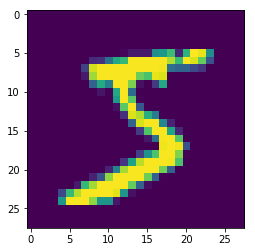

In [87]:
sample = train_loader.dataset[0][0]
sample = np.squeeze(sample)
plt.imshow(sample)

In [91]:
dropout_rate = 0


device = tt.device('cpu')

model = Demo1(dropout_rate).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

n_batches = int(np.ceil(len(train_loader.dataset) / batch_size))

In [92]:
!rm -rf log_demo1
!rm -rf check_demo1
!mkdir mkdir check_demo1

mkdir: mkdir: File exists


In [93]:
train_nn(model, train_loader, val_loader, n_batches, optimizer, criterion, 
         n_epochs=10,
         device=device,
         logdir='log_demo1',
         checkdir='check_demo1',
        )

validation loss=0.1219


validation loss=0.0995


validation loss=0.0848


validation loss=0.0805


validation loss=0.0755


validation loss=0.0736


validation loss=0.0770


validation loss=0.0768


validation loss=0.0758
Epoch     8: reducing learning rate of group 0 to 1.0000e-03.


validation loss=0.0695


,epoch,train_loss,val_loss
0,0,0.148228,0.121885
1,1,0.067759,0.099504
2,2,0.050941,0.084790
3,3,0.075420,0.080528
4,4,0.051296,0.075457
5,5,0.041363,0.073576
6,6,0.032656,0.077027
7,7,0.030780,0.076847
8,8,0.004298,0.075766
9,9,0.013028,0.069466
